# Test Map Interface with Visual Scanning (cluster)

In this solution we want to explore the cluster algorithm to find our pin.
To able to do that, we will prepare both map and pin images before applying
the Kmeans++ Cluster Algorithm. By cleaning up the images, we reduce
uncertainty and complexity out of the search process, making it faster
to converge to an optimal solution.

We begin by importing all the resources we are going to need:

- PIL: library to load and manipulate our images
- matplotlib: library to display our images in this notebook
- numpy: library to manipulate arrays

Here's the full list:

In [ ]:
from collections import deque
from PIL import Image, ImageEnhance
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import statistics
import time

Now, let's load our map and pin images and display them. Instead of using
the whole pin image (slice.png), we decided to keep the most particular
part of the pin. In this case, the center of the pin represents the
best feature possible to use in our search process. 

Here we load the map and the pin feature we are going to use:

In [ ]:
# ---------------------------------------------------------------------
# Loading images
# ---------------------------------------------------------------------

folder = "./data/sample4"

mapimg = Image.open(folder + "/map.png").convert("RGB")
W, H = mapimg.size

pin = Image.open(folder + "/pin_focus.png").convert("RGB")
pin_w, pin_h = pin.size

print("Map  = {0}px x {1}px".format(W, H))
print("Pin  = {0}px x {1}px".format(pin_w, pin_h))

# Display images side-by-side
plt.rcParams["figure.figsize"] = [10, 5]
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(mapimg)
axarr[0].set_title("Map")
axarr[1].imshow(pin)
axarr[1].set_title("Cropped Pin")

## Enhancing images

In the Figure above you can see that both of our images contain a rich collection
of different colors. Each one of the colors here will be represented in our array
as a RGB array, which makes it very difficult to analyzed due to the quantity
of shades and colors we have.

When we look to our pin, we can see that it has a lot of small variations and
gradients, even though it is mostly red. These small variations increase the
number of features (colors) the algorithm needs to look, which makes the
calculations harder to make.

We are going to reduce this number of colors by saturating the images. By using
the ImageEnhancer, we are able to test different levels until we find a value
that satisfies our need of reducing our colors to a single one.

The code below shows the different levels applied to our pin:

In [ ]:
# ---------------------------------------------------------------------
# Find ideal enhance factor
# ---------------------------------------------------------------------

converter = ImageEnhance.Color(pin)

plt.rcParams["figure.figsize"] = [5, 5]
fig, axarr = plt.subplots(4, 4)
i = 0
inc = 10

for x in range(4):
    for y in range(4):
        i = round(i + inc, 2)
        img = converter.enhance(i)
        axarr[x, y].imshow(img)
        axarr[x, y].set_title("i=" + str(i))
        
fig.tight_layout()

ENHANCE_FACTOR = 60


You can see that after `i=3.5`, our pin becomes all red. This is the ideal result
we want because it maintains the single most important color to distinguish our
pin in the map.

We apply `i=4.0` as our enhance level and apply to our map image as well, to make
sure that both images are consistent:

In [ ]:
# ---------------------------------------------------------------------
# Apply same enhancement factor to the map
# ---------------------------------------------------------------------

converter = ImageEnhance.Color(pin)
pin_sat = converter.enhance(ENHANCE_FACTOR)

converter = ImageEnhance.Color(mapimg)
map_sat = converter.enhance(ENHANCE_FACTOR)

# Display images side-by-side
plt.rcParams["figure.figsize"] = [10, 5]
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(map_sat)
axarr[0].set_title("Map")
axarr[1].imshow(pin_sat)
axarr[1].set_title("Pin")

## Creating the Heatmap

The idea of a heatmap is to reduce the noise of our image as much as possible
by creating an array contains only the color we want (HOT) or discarding all
other colors by reducing them to a single color (COLD).

For this example, we are using red as our HOT color and white as our COLD
color to make it easier to see visually. Ideally we should create a Boolean
matrix to represent our map.

The code below takes the original map image, saturate it using the `ENHANCE_FACTOR`
found on the previous step and create the heatmap:

In [ ]:
# ---------------------------------------------------------------------
# Extracting color palette from pin
# ---------------------------------------------------------------------

def extract_palette(image):

    arr = np.array(image)
    (Y, X, Z) = arr.shape

    palette = {}

    for x in range(X):
        for y in range(Y):
            color = tuple(arr[y][x])
            
            if color in palette:
                palette[color] += 1
            else:
                palette[color] = 1

    return palette

def get_most_frequent_color(palette):

    count = 0
    most_frequent_color = None

    for color in palette:
        if palette[color] > count:
            count = palette[color]
            most_frequent_color = color

    return most_frequent_color

# Get palette and most frequent color
pin_palette = extract_palette(pin_sat)
most_frequent_color = get_most_frequent_color(pin_palette)

print("Colors in pin = {}".format(len(pin_palette)))
print("Most frequent color = {}".format(most_frequent_color))


In [ ]:
# ---------------------------------------------------------------------
# Create heatmap
# ---------------------------------------------------------------------

pin_arr = np.array(pin_sat)

HOT  = (255, 0, 0)
COLD = (255, 255, 255)

# Creating heatmap from saturated image
(X, Y) = map_sat.size

map_arr = np.asarray(map_sat)
pin_arr = np.asarray(pin_sat)

map_arr_heat = np.copy(map_arr) # Create copy

for x in range(X):
    for y in range(Y):
        color = tuple(map_arr[y][x])

        if color in pin_palette:
            map_arr_heat[y][x] = HOT
        else:
            map_arr_heat[y][x] = COLD

heatmap = Image.fromarray(map_arr_heat.astype("uint8"), "RGB")

# Display images side-by-side
plt.rcParams["figure.figsize"] = [20, 15]
fig, axarr = plt.subplots(1, 3)
axarr[0].imshow(mapimg)
axarr[0].set_title("Original")
axarr[1].imshow(map_sat)
axarr[1].set_title("Saturated")
axarr[2].imshow(heatmap)
axarr[2].set_title("Heatmap")

## (Optional) Trying different sizes to optimize the code

We tried to resize the image to different sizes to test the impact on
the convergence. We found that resizing the image also decreased the 
precision, resulting in far off estimates. For this example, we found
that working with the original map was good enough and the algorithm 
was not hurt by the size, so we kept the original image.

The code below shows how our features (red dots) are getting degraded
as we resize the original image to smaller sizes:

In [ ]:
# ---------------------------------------------------------------------
# Resize heatmap to different sizes
# ---------------------------------------------------------------------

def resize(image, new_w):
    (w, h) = image.size

    ratio = (new_w / w)
    new_h = int(h * ratio)

    return image.resize((new_w, new_h), Image.Resampling.LANCZOS)

(w, h) = heatmap.size

heatmap2 = resize(heatmap,   int(w/2))
heatmap4 = resize(heatmap,   int(w/4))
heatmap8 = resize(heatmap,   int(w/8))
heatmap16 = resize(heatmap,  int(w/16))
heatmap32 = resize(heatmap,  int(w/32))
heatmap64 = resize(heatmap,  int(w/64))
heatmap128 = resize(heatmap, int(w/128))

# Display images side-by-side
plt.rcParams['figure.figsize'] = [15, 5]

fig, axarr = plt.subplots(2, 4)
axarr[0][0].imshow(heatmap)
axarr[0][1].imshow(heatmap2)
axarr[0][2].imshow(heatmap4)
axarr[0][3].imshow(heatmap8)
axarr[1][0].imshow(heatmap16)
axarr[1][1].imshow(heatmap32)
axarr[1][2].imshow(heatmap64)
axarr[1][3].imshow(heatmap128)

## Finding the coordinates

We proceed by scanning the heatmap, looking for all coordinates marked
as HOT. The code below shows the image size (278, 488) and the number
of HOT coordinates were found:

In [ ]:
# ---------------------------------------------------------------------
# Find coordinates that are not COLD in heatmap
# ---------------------------------------------------------------------

heatmap_selected = heatmap
heatmap_arr = np.asarray(heatmap_selected)
coords = []

(X, Y) = heatmap_selected.size
for x in range(X):
    for y in range(Y):
        rgb = tuple(heatmap_arr[y][x])
        if rgb != COLD:
            coords.append((y, x))

print("        Size =", (X, Y))
print("Total coords =", str(X * Y))
print("    Not cold =", str(len(coords)))

With these coordinates, we proceed by applying the kmeans++ algorithm,
which will generate N clusters for us. The result will be a list of
coordinates, known as centroids, that represent the central coordinate
of each group of HOT dots we found in our heatmap:

In [ ]:
# ---------------------------------------------------------------------
# Find centroid of all NOT COLD coordinates found in heatmap
# ---------------------------------------------------------------------

from sklearn.cluster import KMeans
# TODO: test different variations of clustering: https://scikit-learn.org/stable/modules/clustering.html

kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto").fit(coords)
kmeans.labels_
centroids = kmeans.cluster_centers_

centroids = [ (int(y), int(x)) for (y, x) in centroids ]

print("Centroids = ", centroids)
# %timeit centroidpython(coords)

The code below draws a rectangle around each one of the centroids we found
on the previous step. We can see that of our 5 candidates, at least one
looks promising enough whereas the rest is very far off the answer. We
will address that and filter the results to find the correct solution:

In [ ]:
# ---------------------------------------------------------------------
# Find centroid of all NOT COLD coordinates found in heatmap
# ---------------------------------------------------------------------

# Pin size
(w, h) = pin.size
(w, h) = (w*2, h*2)

# Plot found coordinates (x, y) and correct answer
plt.rcParams["figure.figsize"] = [20, 15]
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(heatmap)
axarr[1].imshow(mapimg)

# Print eligible candidates
for (y, x) in centroids:
    rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor="b", linestyle="--", facecolor="none")
    axarr[0].add_patch(rect)

    rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor="b", linestyle="--", facecolor="none")
    axarr[1].add_patch(rect)

In [ ]:
# ---------------------------------------------------------------------
# Calculate color distance between centroid frames and saturated pin
# ---------------------------------------------------------------------

def colordist(frame, target):
    frame_palette = extract_palette(frame)
    target_palette = extract_palette(target)

    calcd = []
    for color in target_palette:
        a = target_palette[color]
        b = frame_palette[color] if color in frame_palette else 0
        calcd.append((a-b)**2)

    return int(math.sqrt(sum(calcd)))

pin_palette = extract_palette(pin_sat)
print("Centroids color dist:")
i = 0
for centroid in centroids:
    (y, x) = centroid

    frame = map_sat.crop((x - w/2, y - h/2, x + w/2, y + h/2))
    dist = colordist(frame, pin_sat)

    print(str(i) + " centroid = " + str((y, x)) + " dist = " + str(dist))
    i+=1

For each one of the candidates, we calculate how similar the image is to our pin.
To calculate the similarity between the images, we compare each pixel from the
slice we cut from the heatmap with our pin. Since we have only two colors
(HOT and COLD) to evaluate, our calculation becomes much simpler.

Basically, we count how many HOT colors we have in the area cut from the
original heatmap. The area with most HOST pixels wins:

In [ ]:
# ---------------------------------------------------------------------
# Calculate similarity between slices using euclidean distance
# ---------------------------------------------------------------------

def euclidiandist(ta, tb):
    (a1, a2, a3) = ta
    (b1, b2, b3) = tb
    return math.sqrt(math.pow(a1 - b1, 2) + math.pow(a2 - b2, 2) + math.pow(a3 - b3, 2))

def calcdist(slice_arr, target_arr):
    ds = []
    (Y, X, Z) = target_arr.shape
    for x in range(X):
        for y in range(Y):
            ds.append(
                euclidiandist(slice_arr[y][x], target_arr[y][x])
            )

    return int(statistics.mean(ds))

# Get slices by centroids
pin_arr = np.asarray(pin)
(h, w, _) = pin_arr.shape
scores_dict = {}
scores = []
for (y, x) in centroids:

    # Bounds
    # frame = mapimg.crop((x - w/2, y - h/2, x + w/2, y + h/2)) # left, top, right, bottom
    frame = map_sat.crop((x - w/2, y - h/2, x + w/2, y + h/2)) # left, top, right, bottom

    # Calculating score
    if (y, x) not in scores_dict:

        try:
            # score = calcdist(slice_arr=np.asarray(frame), target_arr=pin_arr)
            score = colordist(frame, pin_sat)
        except Exception:
            score = 100000

        scores_dict[(y, x)] = score
        scores.append(score)

# TODO: Create a proper list to store the score and sort it later
# Sorting centroids by its score
scores_dict = dict(sorted(scores_dict.items(), key=lambda item: item[1]))
centroids = []
for (y, x) in scores_dict:
    centroids.append((y, x))

min_score = min(scores)
max_score = max(scores)

print("Dist:")
print("  Min = " + str(min_score))
print("  Max = " + str(max_score))

# Find the best guess
best_coord = None
best_score = max_score
found_idx  = None
i = 0
for coord in scores_dict:
    if scores_dict[coord] < best_score:
        best_score = scores_dict[coord]
        best_coord = coord
        found_idx = i
    i += 1

print("\nBest:")
print("  Index = ", found_idx)
print("  Score = ", best_score)
print("  Guess = ", best_coord)

# Plot centroid slices side by side
plt.rcParams["figure.figsize"] = [15, 15]
fig, axarr = plt.subplots(10, 10)
k=0
for i in range(10):
    for j in range(10):
        (y, x) = centroids[k]

        frame = mapimg.crop((x - w/2, y - h/2, x + w/2, y + h/2))
        title = str(k) + " = " + str(round(scores_dict[(y, x)], 2))
        
        axarr[i][j].imshow(frame)
        axarr[i][j].set_title(title)
        axarr[i][j].axis("off")
        k += 1

## Scanning the surface of each slice iteratively

centroid = (705, 1143)
best_score = 0
(695, 1134) 0


/var/folders/vr/zq1vf6p10s54lh4qxbgv05rh0000gn/T/ipykernel_60983/386655384.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  return math.sqrt(math.pow(a1 - b1, 2) + math.pow(a2 - b2, 2) + math.pow(a3 - b3, 2))


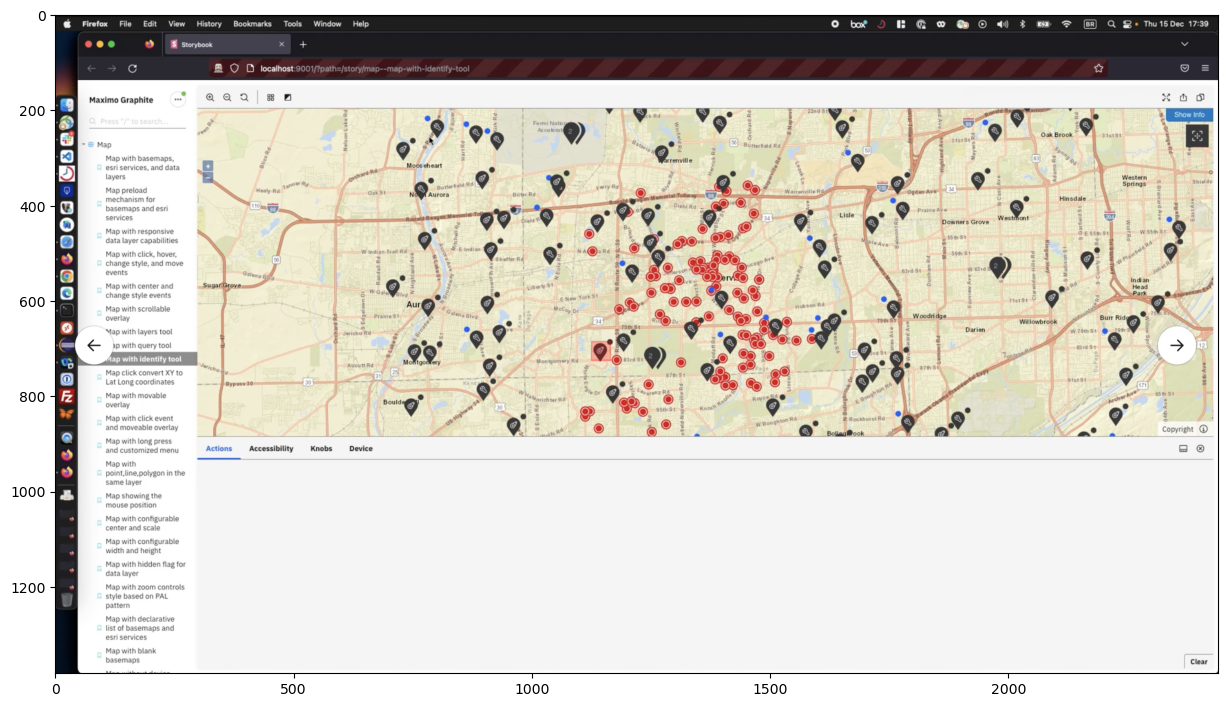

In [13]:
def find_target(frame, target, err = 25, limit=10000):

    frame_arr = np.asarray(frame)
    target_arr = np.asarray(target)

    (Y, X, Z) = frame_arr.shape
    (H, W, Z) = target_arr.shape
    
    y = 0
    x = 0
    dist = 10000

    for y in range(Y - H):
        for x in range(X - W):

            slice_arr = frame_arr[y : y + H, x : x + W]

            dist = calcdist(
                slice_arr=slice_arr,
                target_arr=target_arr
            )

            if dist < err or dist > limit:
                return (y - H, x - W, dist)

    return (y - H, x - W, dist)

# Correct answer
(w, h) = pin.size

best_coord = (None, None)
best_score = max_score
tolerance = 50

for (cy, cx) in centroids:

    slice = mapimg.crop((cx - w, cy - h, cx + w, cy + h))
    (fy, fx, dist) = find_target(slice, pin, limit=10000)

    if dist < best_score:
        best_score = dist
        best_coord = (cy + fy, cx + fx)

    print("centroid = " + str((cy, cx)))
    print("best_score = " + str(best_score))

    if best_score < tolerance:
        break

print(best_coord, best_score)

# Plot found coordinates (x, y) and correct answer
plt.rcParams["figure.figsize"] = [15, 15]
fig, ax = plt.subplots()
ax.imshow(mapimg)

(y, x) = best_coord
rect = patches.Rectangle((x - w/2, y - h/2), w*2, h*2, linewidth=1, edgecolor="r", facecolor="r", alpha=0.25)
ax.add_patch(rect)

## Scanning the surface of each slice using search in depth (graph)

centroid = (705, 1143)
score    = 8
CALL find_target

Best score: (705, 1144, 0)


/var/folders/vr/zq1vf6p10s54lh4qxbgv05rh0000gn/T/ipykernel_60983/386655384.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  return math.sqrt(math.pow(a1 - b1, 2) + math.pow(a2 - b2, 2) + math.pow(a3 - b3, 2))


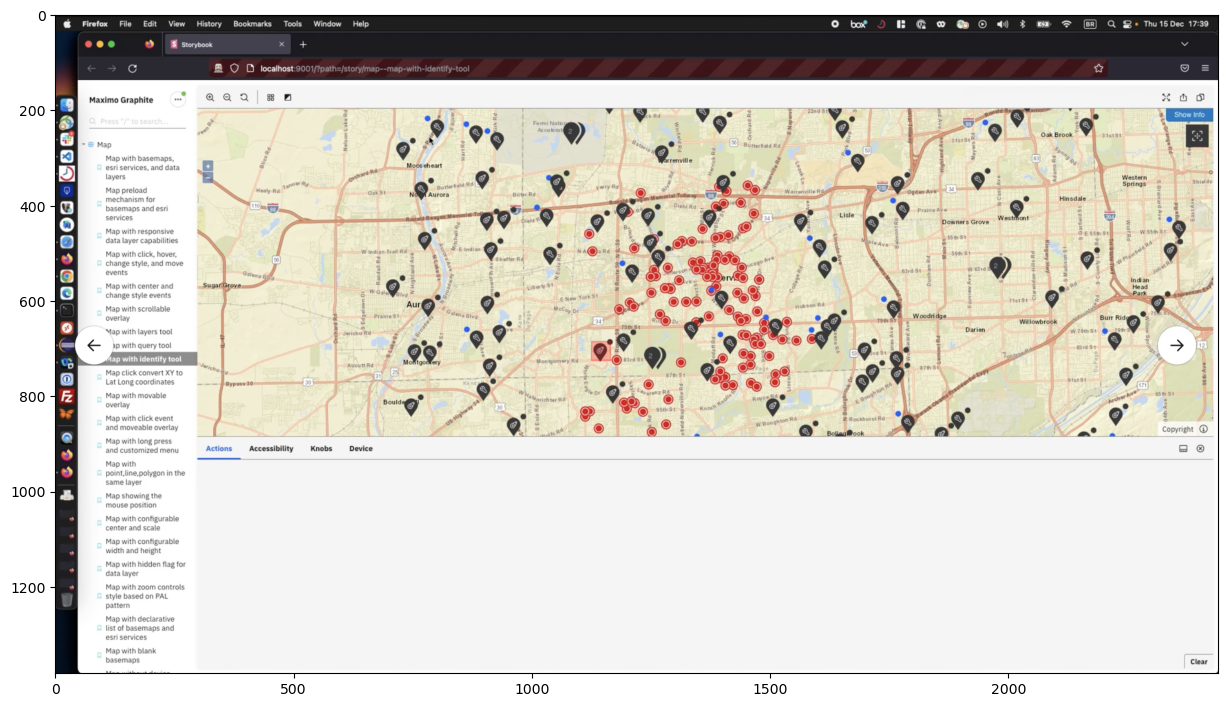

In [14]:
# TODO: Work in progress: trying to do a recursive walk around the center

def dist_from_origin(origin, current):
    (yo, xo) = origin
    (y, x) = current
    return math.sqrt((yo - y)**2 + (xo - x)**2)

def calcdist2(frame, target, pos, size):

    frame_arr = np.asarray(frame)
    target_arr = np.asarray(target)
    
    (y, x) = pos
    (h, w) = size
    (y1, y2, x1, x2) = (int(y - h/2), int(y + h/2), int(x - w/2), int(x + w/2))
    
    return calcdist(
        slice_arr=frame_arr[ y1 : y2, x1 : x2 ],
        target_arr=target_arr
    )

def find_target(origin, size, frame, target, best, seen, q):

    # Queue is empty. Return the best value found
    if len(q) == 0:
        return best

    pos = q.popleft()

    # Position is already seen. Move on to next
    if pos in seen:
        return find_target(origin, size, frame, target, best, seen, q)

    # Mark as seen
    seen.add(pos) 

    # Prevent algorithm from wandering too far from centroid
    if dist_from_origin(origin, pos) > h:
        return find_target(origin, size, frame, target, best, seen, q)

    # Calculate score
    dist = calcdist2(frame, target, pos, size)

    (y, x) = pos
    (by, bx, bscore) = best

    # Score satisfies the error tolerance
    if (dist < 25):
        return (y, x, dist)

    # Current score is better than last. Updates best score
    if dist < bscore:
        best = (y, x, dist)

    q.append((y, x-1))
    q.append((y, x+1))
    q.append((y-1, x))
    q.append((y+1, x))

    return find_target(origin, size, frame, target, best, seen, q)

# Correct answer
(w, h) = pin.size

best_coord = (None, None)
best_score = max_score

q = deque()
seen = set()

# for (cy, cx) in centroids:
for (cy, cx) in [ centroids[0] ]:
    
    print("centroid = " + str((cy, cx)))
    print("score    = " + str(scores_dict[(cy, cx)]))
    print("CALL find_target\n")

    pos = (cy, cx)
    best = (cy, cx, scores_dict[(cy, cx)])

    q.append(pos)

    (fy, fx, dist) = find_target(
        origin = pos,
        size = (h, w),
        frame = mapimg,
        target = pin,
        best = best,
        seen = seen,
        q = q
    )

    if dist < best_score:
        best_score = dist
        best_coord = (cy + fy, cx + fx)

print("Best score:", (fy, fx, dist))

# Plot found coordinates (x, y) and correct answer
plt.rcParams["figure.figsize"] = [15, 15]
fig, ax = plt.subplots()
ax.imshow(mapimg)

(y, x) = best_coord
rect = patches.Rectangle((fx - w, fy - h), w*2, h*2, linewidth=1, edgecolor="r", facecolor="r", alpha=0.25)
ax.add_patch(rect)

# Answer = (943, 1199) 0.0, walk dist = 26

## Plot centroids with best scores

The result above gives us two different sets of answers:

- One coordinate scored a distance of `17.11`, which is very close to the pin,
- The other four scored a distance of more than `300`, which indicates they are very far from our expectations.

Finally, we use this information to plot the most promising coordinate (that scored `17.11`)
against the other candidates. Our answer is represented by a red rectangle, whereas
the other candidates are marked as gray dotted rectangles:

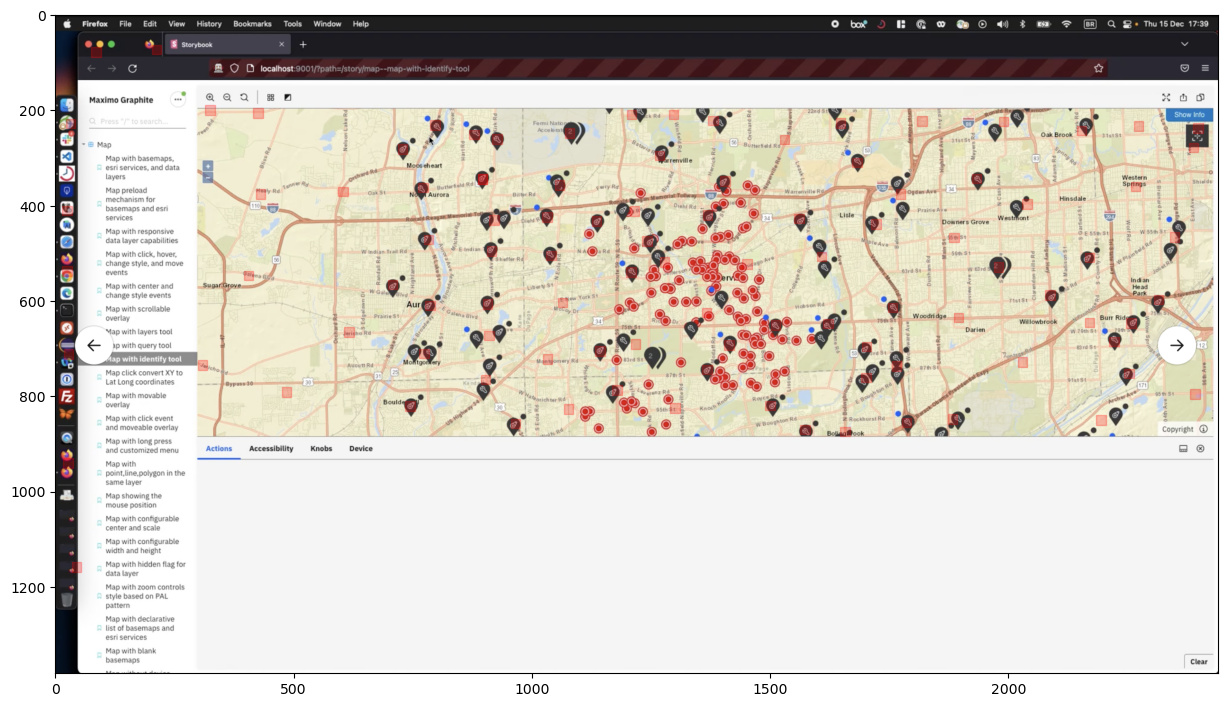

In [17]:
# ---------------------------------------------------------------------
# Plot centroid with smallest distance
# ---------------------------------------------------------------------

# Area
(w, h) = pin.size

# Plot answer
plt.rcParams["figure.figsize"] = [15, 10]
fig, ax = plt.subplots()
ax.imshow(mapimg)

i = 0
for (iy, ix) in centroids:
    rect = patches.Rectangle((ix - w/2, iy - h/2), w, h, linewidth=1, edgecolor="r", facecolor="r", alpha=0.25)
    ax.add_patch(rect)
    i += 1

# Plot best guess
(y, x) = best_coord
rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor="r", facecolor="r", alpha=0.25)
ax.add_patch(rect)

# Correct answer
(y, x) = centroids[17]
rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor="r", facecolor="r", alpha=0.25)
ax.add_patch(rect)

Looks like we found it the right place to click afterall!